In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import files
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import


In [20]:
df = pd.read_csv("survey.csv")

In [21]:
df.head(5)

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

In [23]:
df.drop_duplicates()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2015-09-12 11:17:21,26,male,United Kingdom,NaN,No,No,Yes,NaN,26-100,...,Somewhat easy,No,No,Some of them,Some of them,No,No,Don't know,No,NaN
1255,2015-09-26 01:07:35,32,Male,United States,IL,No,Yes,Yes,Often,26-100,...,Somewhat difficult,No,No,Some of them,Yes,No,No,Yes,No,NaN
1256,2015-11-07 12:36:58,34,male,United States,CA,No,Yes,Yes,Sometimes,More than 1000,...,Somewhat difficult,Yes,Yes,No,No,No,No,No,No,NaN
1257,2015-11-30 21:25:06,46,f,United States,NC,No,No,No,NaN,100-500,...,Don't know,Yes,No,No,No,No,No,No,No,NaN


In [24]:
df.isnull().sum()

,0
Timestamp,0
Age,0
Gender,0
Country,0
state,515
self_employed,18
family_history,0
treatment,0
work_interfere,264
no_employees,0


In [25]:
df['state'] = df["state"].fillna("Not Applicable")
df = df.dropna(subset=['self_employed'])
df['work_interfere'] = df['work_interfere'].fillna("No data")
df['comments'] = df['comments'].fillna("No comments")

<ipython-input-25-206bc56b68e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['work_interfere'] = df['work_interfere'].fillna("No data")
<ipython-input-25-206bc56b68e1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comments'] = df['comments'].fillna("No comments")


In [26]:
df.isnull().sum()

,0
Timestamp,0
Age,0
Gender,0
Country,0
state,0
self_employed,0
family_history,0
treatment,0
work_interfere,0
no_employees,0


In [27]:
df['Gender'].unique()

array(['male', 'Male', 'Female', 'female', 'M', 'm', 'Male-ish', 'maile',
       'Trans-female', 'Cis Female', 'F', 'something kinda male?',
       'Cis Male', 'Woman', 'f', 'Mal', 'Male (CIS)', 'queer/she/they',
       'non-binary', 'Femake', 'woman', 'Make', 'Nah', 'All', 'Enby',
       'fluid', 'Genderqueer', 'Female ', 'Androgyne', 'Agender',
       'cis-female/femme', 'Guy (-ish) ^_^', 'male leaning androgynous',
       'Male ', 'Man', 'Trans woman', 'msle', 'Neuter', 'Female (trans)',
       'queer', 'Female (cis)', 'Mail', 'cis male', 'A little about you',
       'Malr', 'p', 'femail', 'Cis Man',
       'ostensibly male, unsure what that really means'], dtype=object)

In [28]:
df['Gender'] = df['Gender'].str.lower()
gender_mapping = {
    'male' : ['male', 'm', 'male-ish', 'maile', 'make', 'mal', 'man', 'msle',
             'mail', 'malr', 'something kinda male?',
             'cis male', 'male (cis)', 'guy (-ish) ^_^', 'male ', 'cis man',
             'ostensibly male, unsure what that really means'],
    'female' : ['female', 'female ', 'f', 'woman', 'femake', 'female (cis)',
               'femail', 'cis female', 'cis-female/femme'],
    'other' : ['trans-female', 'something else', 'non-binary', 'neuter',
              'female (trans)', 'queer/she/they', 'nah', 'all', 'enby', 'fluid',
              'genderqueer', 'androgyne',
              'agender', 'male leaning androgynous', 'trans woman', 'queer',
              'a little about you', 'p']
}

df['Standardized_gender'] = df['Gender'].apply(lambda x: next((key for key, value in gender_mapping.items() if x in value), x))



In [29]:
df['Gender'].value_counts()

,count
Gender,
male,810
female,178
m,148
f,53
woman,4
make,4
male,3
cis male,3
female,2


In [30]:
gender_counts = df['Standardized_gender'].value_counts()
gender_counts

,count
Standardized_gender,
male,981
female,242
other,18


In [31]:
df['Age'].unique()

array([         46,          36,          29,          31,          41,
                33,          35,          34,          37,          32,
                30,          42,          40,          27,          38,
                50,          24,          18,          28,          26,
                22,          44,          23,          19,          25,
                39,          45,          21,         -29,          43,
                56,          60,          54,         329,          55,
       99999999999,          48,          20,          57,          58,
                47,          62,          51,          65,          49,
             -1726,           5,          53,          61,           8,
                11,          -1,          72])

In [32]:
df = df[(df['Age'] > 14) & (df['Age'] < 140)]

In [33]:
df.to_csv('cleaned_df.csv', index=False)
files.download('cleaned_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-34-e829cfabb495>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='pastel')


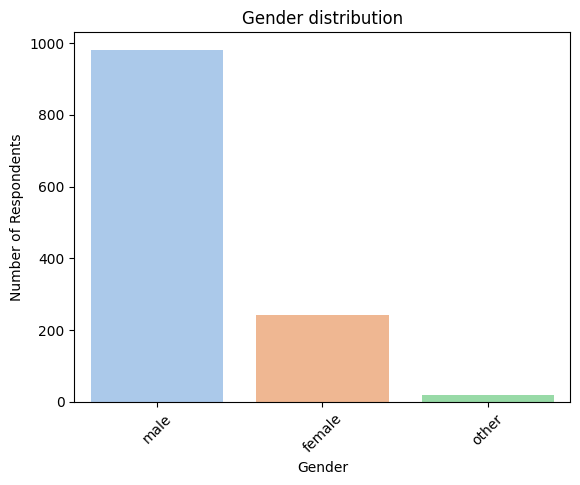

In [34]:
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='pastel')
plt.xlabel('Gender')
plt.ylabel('Number of Respondents')
plt.title('Gender distribution')
plt.xticks(rotation=45)
plt.show()

<ipython-input-35-f4d879e20267>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=self_emp_count.index, y=self_emp_count.values, palette='pastel')


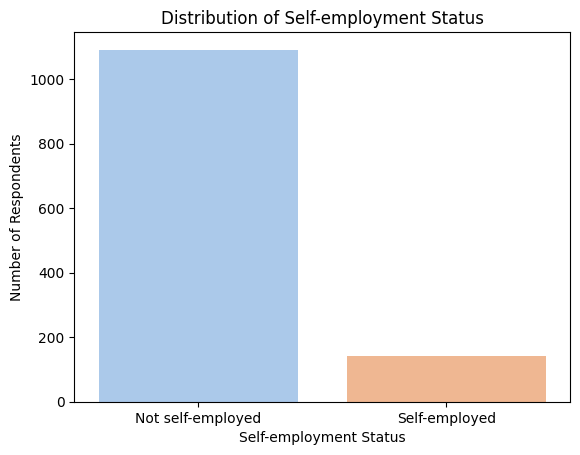

In [35]:
self_emp_count = df['self_employed'].replace({'Yes':'Self-employed','No':'Not self-employed'}).value_counts()
sns.barplot(x=self_emp_count.index, y=self_emp_count.values, palette='pastel')
plt.ylabel('Number of Respondents')
plt.xlabel('Self-employment Status')
plt.title('Distribution of Self-employment Status')
plt.show()

<ipython-input-36-7f0861b84c60>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=remote_counts.index, y=remote_counts.values, palette='pastel')


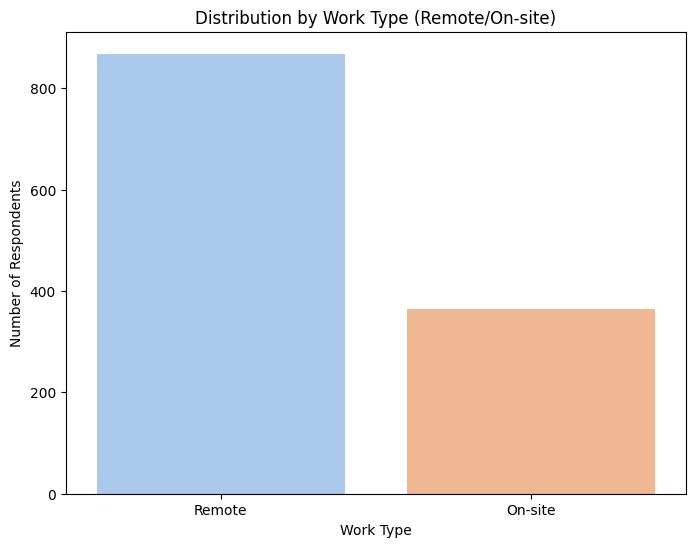

In [36]:
# Подсчет количества респондентов по типу работы
remote_counts = df['remote_work'].replace({'Yes': 'On-site', 'No': 'Remote'}).value_counts()

# Визуализация распределения по типу работы
plt.figure(figsize=(8, 6))
sns.barplot(x=remote_counts.index, y=remote_counts.values, palette='pastel')
plt.title('Distribution by Work Type (Remote/On-site)')
plt.xlabel('Work Type')
plt.ylabel('Number of Respondents')
plt.show()


<ipython-input-37-3eefa25823ae>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='remote_work', y='work_interfere', data=df, palette='pastel')


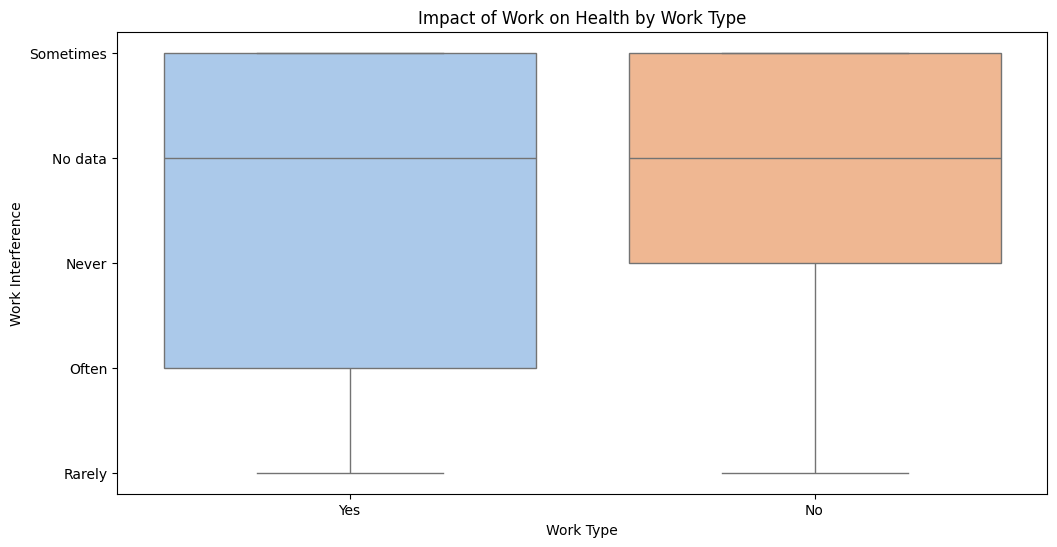

<ipython-input-37-3eefa25823ae>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='remote_work', y='treatment', data=df, palette='pastel')


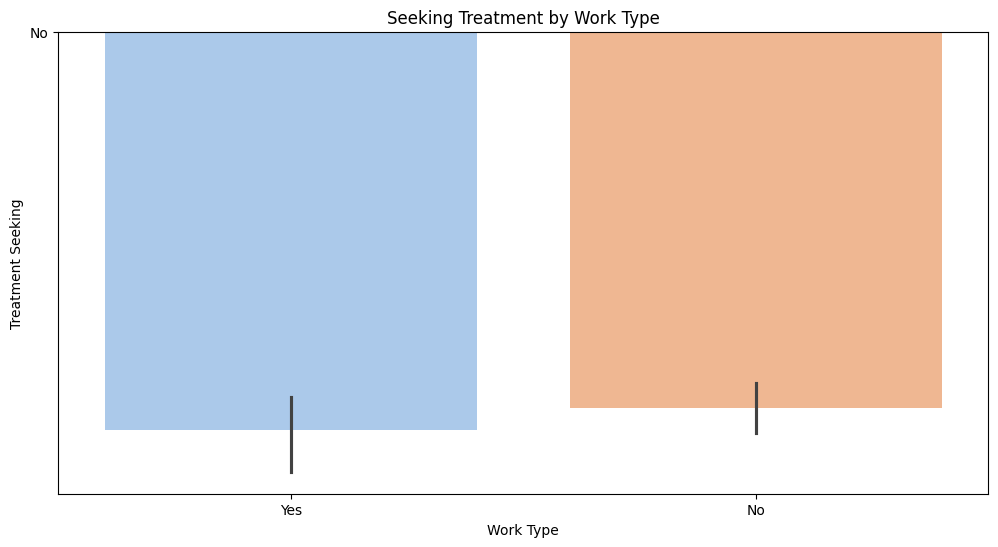

In [37]:
# Boxplot: Impact of work on health by work type
plt.figure(figsize=(12, 6))
sns.boxplot(x='remote_work', y='work_interfere', data=df, palette='pastel')
plt.title('Impact of Work on Health by Work Type')
plt.xlabel('Work Type')
plt.ylabel('Work Interference')
plt.show()

# Barplot: Analysis of remote work impact on treatment
plt.figure(figsize=(12, 6))
sns.barplot(x='remote_work', y='treatment', data=df, palette='pastel')
plt.title('Seeking Treatment by Work Type')
plt.xlabel('Work Type')
plt.ylabel('Treatment Seeking')
plt.show()


In [38]:
remote_counts

,count
remote_work,
Remote,868
On-site,365


In [39]:
remote_counts /remote_counts.sum()

,count
remote_work,
Remote,0.703974
On-site,0.296026


<ipython-input-40-8d930585b0de>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=family_history_count.index, y=family_history_count.values, palette='pastel')


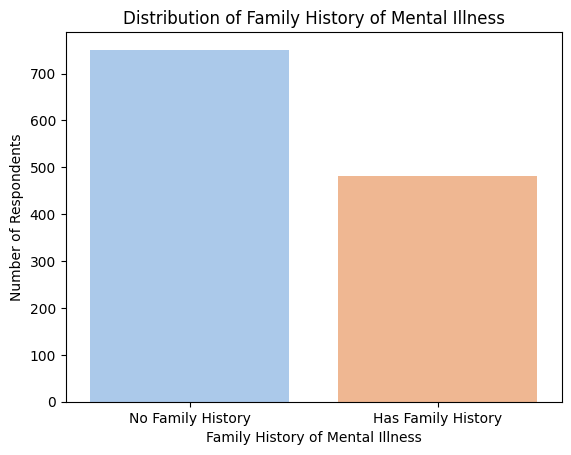

In [40]:
family_history_count = df['family_history'].replace({'Yes': 'Has Family History', 'No': 'No Family History'}).value_counts()

sns.barplot(x=family_history_count.index, y=family_history_count.values, palette='pastel')
plt.title('Distribution of Family History of Mental Illness')
plt.xlabel('Family History of Mental Illness')
plt.ylabel('Number of Respondents')
plt.show()

In [41]:
contingency_table = pd.crosstab(df['family_history'], df['treatment'])
contingency_table

treatment,No,Yes
family_history,,
No,485,266
Yes,125,357


In [42]:
contingency_table = pd.crosstab(df['family_history'], df['treatment']) #таблица сопряженности
print(contingency_table)

treatment        No  Yes
family_history          
No              485  266
Yes             125  357


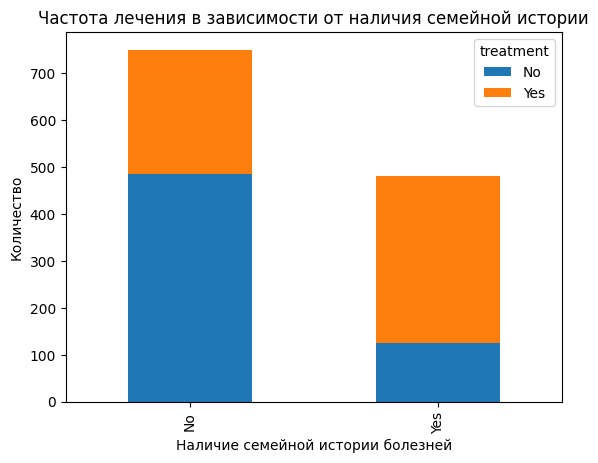

Chi2: 173.87069153071008, p-value: 1.0563870202809049e-39
Существует значимая связь между наличием семейной истории и принятием лечения.


In [43]:
contingency_table.plot(kind='bar', stacked=True)
plt.xlabel('Наличие семейной истории болезней')
plt.ylabel('Количество')
plt.title('Частота лечения в зависимости от наличия семейной истории')
plt.show()


chi2, p, _, _ = chi2_contingency(contingency_table) #критерий хи-квадрат
print(f'Chi2: {chi2}, p-value: {p}')


if p < 0.05:
    print('Существует значимая связь между наличием семейной истории и принятием лечения.')
else:
    print('Связь между наличием семейной истории и принятием лечения незначима.')


In [44]:
selected_features = ['Age', 'Gender', 'self_employed', 'family_history', 'work_interfere',
                     'no_employees', 'remote_work', 'tech_company', 'benefits',
                     'care_options', 'wellness_program', 'seek_help', 'anonymity',
                     'leave', 'mental_health_consequence', 'phys_health_consequence',
                     'coworkers', 'supervisor', 'mental_health_interview',
                     'phys_health_interview', 'mental_vs_physical', 'obs_consequence']

df_selected = df[selected_features + ['treatment']]

categorical_columns = ['Gender', 'self_employed', 'family_history', 'work_interfere',
                       'no_employees', 'remote_work', 'tech_company', 'benefits',
                       'care_options', 'wellness_program', 'seek_help', 'anonymity',
                       'leave', 'mental_health_consequence', 'phys_health_consequence',
                       'coworkers', 'supervisor', 'mental_health_interview',
                       'phys_health_interview', 'mental_vs_physical', 'obs_consequence']
df_encoded = pd.get_dummies(df_selected, columns=categorical_columns)


scaler = StandardScaler()

# Стандартизируем возраст
df_encoded['Age'] = scaler.fit_transform(df_encoded[['Age']])



In [47]:
X = df_encoded.drop('treatment', axis=1)
y= df_encoded['treatment']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)

In [48]:
# Создаем экземпляр модели логистической регрессии
log_reg = LogisticRegression(max_iter=1000)

# Обучаем модель
log_reg.fit(X_train, y_train)

# Предсказываем на тестовых данных
y_pred_log_reg = log_reg.predict(X_test)

# Оценка модели
print("Логистическая регрессия:")
print("Точность:", accuracy_score(y_test, y_pred_log_reg))
print(classification_report(y_test, y_pred_log_reg))

Логистическая регрессия:
Точность: 0.8135135135135135
              precision    recall  f1-score   support

           0       0.86      0.76      0.81       191
           1       0.78      0.87      0.82       179

    accuracy                           0.81       370
   macro avg       0.82      0.82      0.81       370
weighted avg       0.82      0.81      0.81       370



In [49]:
# Создаем экземпляр модели Random Forest
rf_model = RandomForestClassifier(random_state=99)

# Обучаем модель
rf_model.fit(X_train, y_train)

# Предсказываем на тестовых данных
y_pred_rf = rf_model.predict(X_test)

# Оценка модели
print("Random Forest:")
print("Точность:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest:
Точность: 0.827027027027027
              precision    recall  f1-score   support

           0       0.87      0.79      0.82       191
           1       0.79      0.87      0.83       179

    accuracy                           0.83       370
   macro avg       0.83      0.83      0.83       370
weighted avg       0.83      0.83      0.83       370



In [50]:
rf_model = RandomForestClassifier(random_state=99)

# Задаем гиперпараметры для поиска
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
}



grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                               cv=5, scoring='accuracy', verbose=2, n_jobs=-1)


grid_search_rf.fit(X_train, y_train)


print("Лучшие параметры Random Forest:", grid_search_rf.best_params_)
print("Лучшая точность:", grid_search_rf.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Лучшие параметры Random Forest: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50}
Лучшая точность: 0.8272953353945424


In [51]:
import xgboost as xgb

# Создаем экземпляр модели XGBoost
xgb_model = xgb.XGBClassifier(random_state=99)


xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost:")
print("Точность:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost:
Точность: 0.8054054054054054
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       191
           1       0.77      0.84      0.81       179

    accuracy                           0.81       370
   macro avg       0.81      0.81      0.81       370
weighted avg       0.81      0.81      0.81       370



In [52]:
xgb_model = xgb.XGBClassifier(random_state=99)

# Задаем гиперпараметры для поиска
param_dist_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

# Инициализируем RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist_xgb,
                                        n_iter=50, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

random_search_xgb.fit(X_train, y_train)

print("Лучшие параметры XGBoost:", random_search_xgb.best_params_)
print("Лучшая точность:", random_search_xgb.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшие параметры XGBoost: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Лучшая точность: 0.8308038714881032


In [53]:
# Создаем экземпляр модели SVM
svm_model = SVC(random_state=99)

svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

print("SVM:")
print("Точность:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM:
Точность: 0.8297297297297297
              precision    recall  f1-score   support

           0       0.95      0.71      0.81       191
           1       0.75      0.96      0.85       179

    accuracy                           0.83       370
   macro avg       0.85      0.83      0.83       370
weighted avg       0.86      0.83      0.83       370



In [54]:
svm_model = SVC(random_state=99)

# Задаем гиперпараметры для поиска
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],  # разные ядра
    'gamma': ['scale', 'auto']
}

# Инициализируем GridSearchCV
grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid_svm,
                                cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

grid_search_svm.fit(X_train, y_train)

print("Лучшие параметры SVM:", grid_search_svm.best_params_)
print("Лучшая точность:", grid_search_svm.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Лучшие параметры SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Лучшая точность: 0.8319666621857777


In [55]:
pip install lightgbm


In [56]:
pip install dask[dataframe]


INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 kB 2.0 MB/s eta 0:00:00


In [57]:
X_train.columns = X_train.columns.str.replace('[^a-zA-Z0-9]', '_', regex=True)


In [58]:

# Настройка параметров для Gradient Boosting
gb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# Оптимизация гиперпараметров для Gradient Boosting
gb_clf = GradientBoostingClassifier()
gb_grid = GridSearchCV(gb_clf, gb_params, cv=5, scoring='accuracy', n_jobs=-1)
gb_grid.fit(X_train, y_train)

# Лучшие параметры и точность
print("Лучшие параметры Gradient Boosting:", gb_grid.best_params_)
print("Лучшая точность Gradient Boosting:", gb_grid.best_score_)




Лучшие параметры Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Лучшая точность Gradient Boosting: 0.8319666621857777


In [59]:
# Настройка параметров для LightGBM
lgb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [-1, 5, 10],
    'num_leaves': [31, 63]
}

# Оптимизация гиперпараметров для LightGBM
lgb_clf = LGBMClassifier()
lgb_grid = GridSearchCV(lgb_clf, lgb_params, cv=5, scoring='accuracy', n_jobs=-1)
lgb_grid.fit(X_train, y_train)

# Лучшие параметры и точность
print("Лучшие параметры LightGBM:", lgb_grid.best_params_)
print("Лучшая точность LightGBM:", lgb_grid.best_score_)

[LightGBM] [Info] Number of positive: 444, number of negative: 419
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 863, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.514484 -> initscore=0.057954
[LightGBM] [Info] Start training from score 0.057954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
